Saving us.csv to us (1).csv
Epoch 1/50
159/159 [==============================] - 1s 6ms/step - loss: 2.2436
Epoch 2/50
159/159 [==============================] - 0s 1ms/step - loss: 2.1601
Epoch 3/50
159/159 [==============================] - 0s 1ms/step - loss: 2.0621
Epoch 4/50
159/159 [==============================] - 0s 1ms/step - loss: 2.0052
Epoch 5/50
159/159 [==============================] - 0s 1ms/step - loss: 1.9893
Epoch 6/50
159/159 [==============================] - 0s 1ms/step - loss: 1.9880
Epoch 7/50
159/159 [==============================] - 0s 1ms/step - loss: 1.9938
Epoch 8/50
159/159 [==============================] - 0s 1ms/step - loss: 1.9687
Epoch 9/50
159/159 [==============================] - 0s 1ms/step - loss: 1.9684
Epoch 10/50
159/159 [==============================] - 0s 949us/step - loss: 1.9647
Epoch 11/50
159/159 [==============================] - 0s 950us/step - loss: 1.9592
Epoch 12/50
159/159 [==============================] - 0s 1ms/step - loss: 

0.01111579

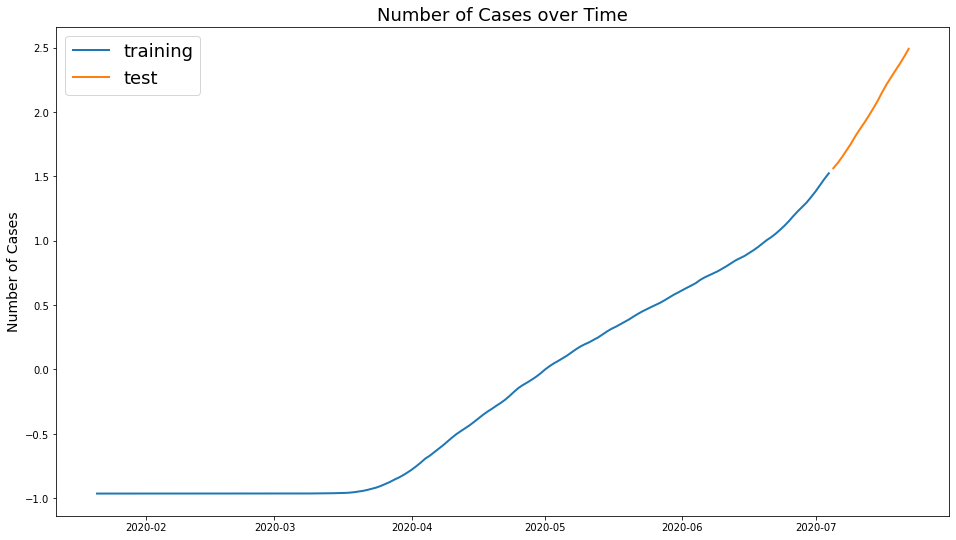

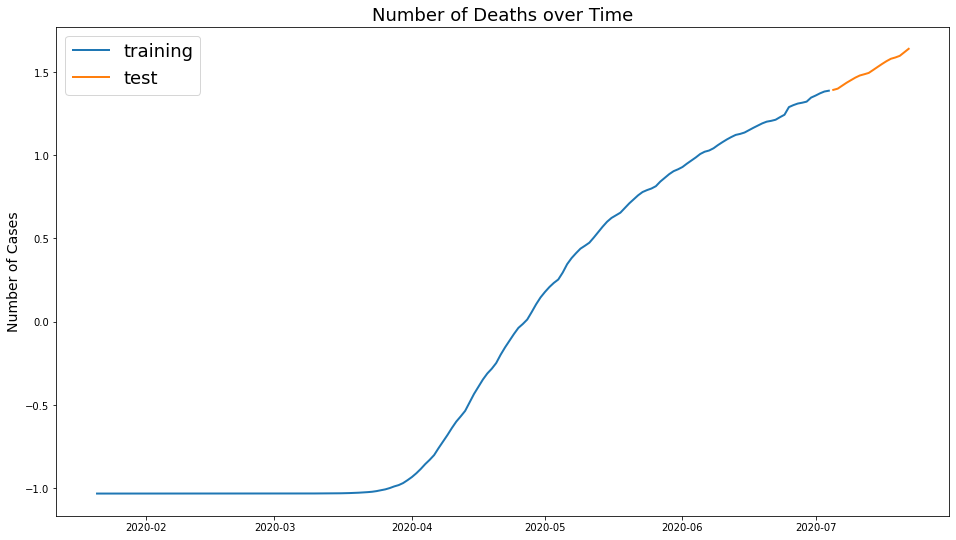

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import io
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from google.colab import files

uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['us.csv']))

num_days = 184

daily_cases = np.zeros(num_days);
cumulative_cases = np.zeros(num_days);

daily_deaths = np.zeros(num_days)
cumulative_deaths = np.zeros(num_days)

days = np.zeros(num_days)

for row in range(0,num_days):

    num_cases = (dataset.loc[row, 'cases'])
    num_deaths = (dataset.loc[row,'deaths'])

    cumulative_cases[row] = num_cases
    cumulative_deaths[row] = num_deaths
    if row == 0:
        daily_cases[row] = num_cases
        daily_deaths[row] = num_deaths
    else:
        daily_cases[row] = num_cases - cumulative_cases[row-1]
        daily_deaths[row] = num_deaths - cumulative_deaths[row - 1]


    days[row] = row

dataset = dataset.set_index('date')
dataset.index = pd.to_datetime(dataset.index)
dataset['cases'] = StandardScaler().fit_transform(dataset['cases'].values.reshape(-1,1))
dataset['deaths'] = StandardScaler().fit_transform(dataset['deaths'].values.reshape(-1,1))
dataset.head()

target_col = 'cases'
target_row = 'deaths'

dataset = dataset.astype('float32')

def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train_size = int(len(dataset)*0.67)
train_size = len(dataset) - train_size
train, test = train_test_split(dataset, test_size=0.1)

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16,9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Number of Cases', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

line_plot(train[target_col], test[target_col], 'training', 'test', title='Number of Cases over Time')
line_plot(train[target_row], test[target_row], 'training', 'test', title='Number of Deaths over Time')

def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def extract_window_data(df, window_len=10, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

np.random.seed(42)

window_len = 7
test_size = 0.1
zero_base = True

lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

train, test, X_train, X_test, y_train, y_test = prepare_data(
    dataset, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

mean_absolute_error(preds, y_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import io
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from google.colab import files

uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['statedata1.csv']))

num_days = 49

daily_cases = np.zeros(num_days);
cumulative_cases = np.zeros(num_days);

daily_deaths = np.zeros(num_days)
cumulative_deaths = np.zeros(num_days)

days = np.zeros(num_days)

for row in range(0,num_days):

    num_cases = (dataset.loc[row, 'Deaths'])
    num_deaths = (dataset.loc[row,'Hospitals'])

    cumulative_cases[row] = num_cases
    cumulative_deaths[row] = num_deaths
    if row == 0:
        daily_cases[row] = num_cases
        daily_deaths[row] = num_deaths
    else:
        daily_cases[row] = num_cases - cumulative_cases[row-1]
        daily_deaths[row] = num_deaths - cumulative_deaths[row - 1]


    days[row] = row

dataset = dataset.set_index('Deaths')
dataset.index = pd.to_datetime(dataset.index)
dataset['Deaths'] = StandardScaler().fit_transform(dataset['Deaths'].values.reshape(-1,1))
dataset['Hospitals'] = StandardScaler().fit_transform(dataset['Hospitals'].values.reshape(-1,1))
dataset.head()

target_col = 'Deaths'
target_row = 'Hospitals'

dataset = dataset.astype('float32')

def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train_size = int(len(dataset)*0.67)
train_size = len(dataset) - train_size
train, test = train_test_split(dataset, test_size=0.1)

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16,9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Number of Cases', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18);

line_plot(train[target_col], test[target_col], 'training', 'test', title='Number of Cases over Time')
line_plot(train[target_row], test[target_row], 'training', 'test', title='Number of Deaths over Time')

def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (df.max() - df.min())

def extract_window_data(df, window_len=10, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

np.random.seed(42)

window_len = 7
test_size = 0.1
zero_base = True

lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

train, test, X_train, X_test, y_train, y_test = prepare_data(
    dataset, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

mean_absolute_error(preds, y_test)

Saving statedata1.csv to statedata1 (7).csv


KeyError: ignored